In [15]:
import pyreadr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio

In [16]:
import torch
print(torch.__version__)
import torch_sparse
# pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.4.0+cpu.html

from torch_geometric.transforms import RadiusGraph
from torch_geometric.data import Data
from torch_geometric.transforms import RandomNodeSplit
import torch.nn.functional as F

2.1.0+cu121


### Preprocess procedure:
1. **Filter needed ligand-target pairs and get top n% high potential score pairs**: 
   -Get `ligand to target` mouse datas from `nichenet2.0` database, which is a dataframe containing `22521 rows(targets) × 1287 columns(ligands)`. Nichenet2.0 gives the caculated **scores** from different ligand-target pairs, which all comes from mouse and brain. Screen them out with efficient LtoR pairs and then get `filtered_lt` with `(974, 120)`
   - Select Top n% high potential score pairs as `top_df` and screen out all ligand family names and downstream targets names based on `connectome` database(the ligand family names are all stored in column `mode`, and with `Ligand.ApprovedSymbol`). The downstream genes come from `target` of `top_df`, and ligand names come from `ligand` of `top_df`.
   - Finally, we get information of ligand names with different ligand family names and downstream targets names from top `n%` high expressed pairs from `nichenet2.0` and `connectome` database.
2. **Prepare training and testing dataset**:
   - We use processed `STARmap` dataset with coordinate information `coor_df` and normalized gene expression data `expr_df` as the input, which is a dataframe containing `1170 rows (cells) × 1020 columns (genes without ensured sender or receiver)`.
   - Then, use `RadiusGraph` to module our input, which is as `Data(x=[1170, 25], y=[1170, 683], pos=[1170, 2], labels=[1170, 16], edge_index=[2, 12062], train_mask=[1170], val_mask=[1170], test_mask=[1170])`. We split it as `RandomNodeSplit(num_val=0.1, num_test=0.1)`, which means train: test: validate = 8:1:1

### 1. Ligand-target database and ligand family database

**Breif Introduction To DataBase**
- [`nichenet2.0`](https://zenodo.org/records/7074291): Published in Sep 2022, a database of ligand-target matrices and ligand family information.(with mouse and human data)
- [`connectome`](https://www.nature.com/articles/ncomms8866): Published22 July 2015, Ramilowski, J., Goldberg, T., Harshbarger, J. et al. A draft network of ligand–receptor-mediated multicellular signalling in human. Nat Commun.
- [`Cortex STARmap Data`](https://www.biorxiv.org/content/10.1101/2023.08.24.554722v1.full.pdf): STARmap published paper link can be see here -> [STARmap](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6339868/)


In [18]:
## ligand-target database: nichenet
niche_path = '../database/nichenet2.0/'

## human
# gr_hs = pyreadr.read_r(niche_path + 'gr_network_human_21122021.rds')[None]
# ligand_receptor_hs = pyreadr.read_r(niche_path + 'lr_network_human_21122021.rds')[None]
# signaling_hs = pyreadr.read_r(niche_path + 'signaling_network_human_21122021.rds')[None]
# ligand_target_hs = pyreadr.read_r(niche_path + 'ligand_target_matrix_nsga2r_final.rds')[None]
# ligand_tf_hs = pyreadr.read_r(niche_path + 'ligand_tf_matrix_nsga2r_final.rds')[None]

## mouse
gr_ms = pyreadr.read_r(niche_path + 'gr_network_mouse_21122021.rds')[None]
ligand_receptor_ms = pyreadr.read_r(niche_path + 'lr_network_mouse_21122021.rds')[None]
# signaling_ms = pyreadr.read_r(niche_path + 'signaling_network_mouse_21122021.rds')[None]  ### have some problem in reading data
ligand_target_ms = pyreadr.read_r(niche_path + 'ligand_target_matrix_nsga2r_final_mouse.rds')[None] ### ligand to target 22521 rows × 1287 columns

ligand_target = ligand_target_ms

### 2. Input datasets and filtering with threshold

The threshold varies depending on the dataset.

### filtering LR pairs by genes detected in ST data

- Get dataframe `expr_df`: Own dataset in left has 1170 rows × 1020 columns
- Filter out contained genes in nichnet 2.0 `ligand_target`, then we get `filtered_lt` dataframe with 974 rows × 120 columns
- Set threshould Top `n`% as potential communicated pairs. And use it as a condition to filter out the ligand families.

`GetThreshold` function usage:
- `top_df`: Dataframe keeping Top `n`% of scores across all.
- `melted_df`: Raw dataframe with columns ligand, target and value.
- `threshold`: Threshold score for selecting top ligands.

In [23]:
def GetFiles(brain_data, file_path):
    if brain_data == 'left':
        coor_path = file_path + 'left_coordinate.csv'
        expr_path = file_path + 'left_norm.csv'
        celltype_path = file_path + 'left_labels.csv'
    elif brain_data == 'right':
        coor_path = file_path + 'right_coordinate.csv'
        expr_path = file_path + 'right_norm.csv'
        celltype_path = file_path + 'right_labels.csv'
        
    return coor_path, expr_path, celltype_path

In [24]:
file_path = '../dataset_STARmap/'
brain_data = 'left'
coor_path, expr_path, celltype_path = GetFiles(brain_data, file_path)

expr_df = pd.read_csv(expr_path)
print(expr_df.shape)
row_filter = ligand_target.index.isin(expr_df.columns)
col_filter = ligand_target.columns.isin(expr_df.columns)
filtered_lt = ligand_target.loc[row_filter, col_filter]

print(filtered_lt.shape)

(1170, 1020)
(974, 120)


In [28]:
coor_df = pd.read_csv(coor_path)
combine_df = coor_df.join(expr_df, how='outer')
# combine_df

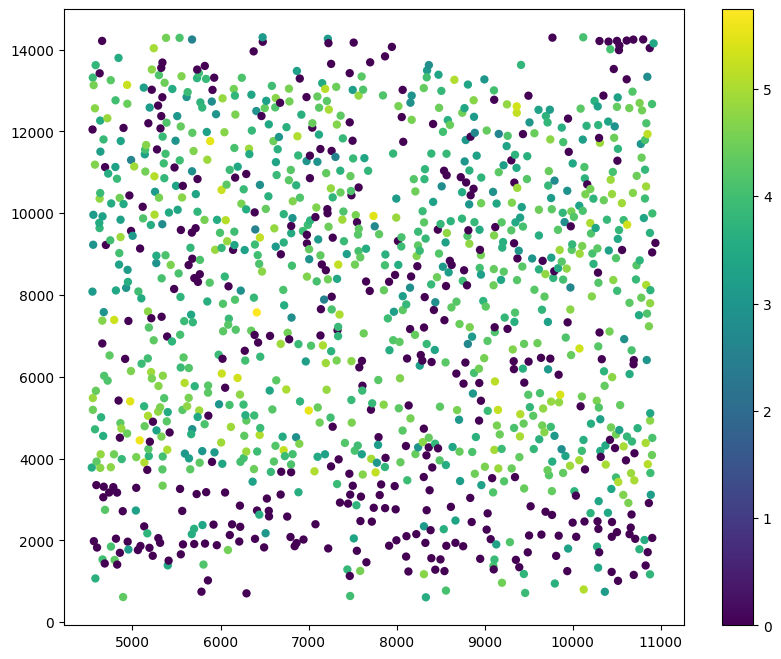

In [29]:
x = combine_df['X']
y = combine_df['Y']
gene_name  = 'Slc17a7'
gexp = combine_df[gene_name]

fig, ax = plt.subplots(figsize = (10, 8))
graph = ax.scatter(x, y, c = gexp, cmap = 'viridis', edgecolors = 'none')
fig.colorbar(graph)

In [31]:
def GetThreshold(df, n):
    melted = df.melt(ignore_index=False).reset_index()
    melted.columns = ['Target', 'Ligand', 'Value']
    sorted_value = sorted(melted.Value, reverse=True)
    top_percent = int(len(sorted_value) * n / 100)
    top_percent = max(top_percent, 1)
    # threshold = sorted_value[top_percent - 1]
    threshold = sorted_value[top_percent]
    print(f"Threshold: {threshold}")
    top_df = melted.loc[melted.Value >= threshold]
    return threshold,top_df, melted

In [32]:
df = filtered_lt.copy()
threshold, top_df, melted_df = GetThreshold(df,1) ## Top n%

Threshold: 0.02922955790174978


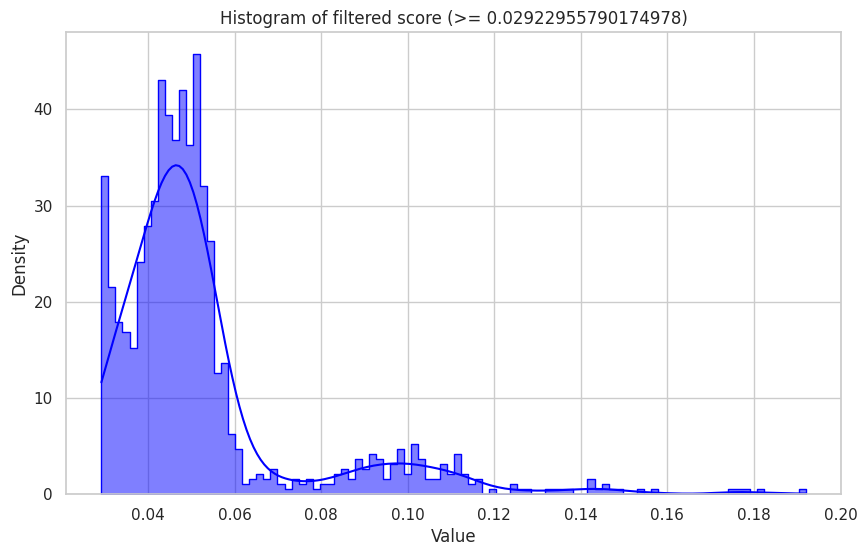

In [33]:
# filterd by 5% ligand-target pairs (for each dataset)
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
sns.histplot(top_df.Value, kde=True, element='step', stat='density', bins=100, color='blue')
plt.title(f"Histogram of filtered score (>= {threshold})")
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

### 3. Ligand family

- ligand family database: `connectome`, only keep `mode`(family branch) and `Ligand.ApprovedSymbol`(gene name) to get `ligand_family` table.
- Filter ligand_family DataFrame to only include those in `top_df.Ligands`
- ligand family: pathway


In [36]:
connectome_path = '../database/connectome/'
connectome_ms = pd.read_csv(connectome_path + 'ncomms8866_mouse.csv', index_col=0)
# print('connectome_ms database:\n',connectome_ms.head())
ligand_family = connectome_ms.loc[:, ['Ligand.ApprovedSymbol', 'mode']].drop_duplicates()
print('ligand_family:\n',ligand_family.head(),len(ligand_family['mode'].unique()))

ligand_family:
   Ligand.ApprovedSymbol                 mode
1                   A2m  Protease inhibition
2                 Aanat                UNCAT
4                   Ace                UNCAT
6                Adam10                 ADAM
8                Adam12                 ADAM 46


In [37]:
print(top_df.Ligand.unique())
filtered_ligand_family = ligand_family[ligand_family['Ligand.ApprovedSymbol'].isin(top_df.Ligand.unique())]
mode_counts = filtered_ligand_family['mode'].value_counts()
print(mode_counts)
filterd_family = mode_counts.index.tolist()

['Adamts3' 'Adcyap1' 'Adm' 'Agt' 'Apod' 'Apoe' 'Avp' 'B2m' 'Bdnf' 'Bmp3'
 'Calca' 'Cck' 'Cd200' 'Cd7' 'Cd9' 'Cdh9' 'Col6a1' 'Crh' 'Dcn' 'Efna5'
 'Elfn1' 'Epha4' 'Fst' 'Grp' 'Igf1' 'Inhba' 'Lgals1' 'Nectin3' 'Ngf' 'Npy'
 'Nrg1' 'Nts' 'Nxph2' 'Pcdha7' 'Pcdha8' 'Penk' 'Pnoc' 'Prok2' 'Pthlh'
 'Ptn' 'Reln' 'Rspo1' 'S100b' 'Sparc' 'Sst' 'Stx1a' 'Tac1' 'Tac2' 'Vgf'
 'Vip']
mode
UNCAT                   18
Vasoactive               3
BMP                      2
Cell-cell adhesion       2
Transferrin              1
APOE                     1
Collagens                1
EGF                      1
MET                      1
Neurotrophins            1
Ephrins                  1
IGF                      1
TGFB                     1
Opiod                    1
NEGF                     1
Matrix glycoproteins     1
WNT                      1
Complement               1
Name: count, dtype: int64


In [38]:
# Select one single family, except 0 (UNCAT)
selecte_family = filterd_family[9]
print('filterd_family name', filterd_family[9]) ## Neurotrophins
filterd_ligand = filtered_ligand_family.loc[filtered_ligand_family['mode'] == selecte_family, 'Ligand.ApprovedSymbol'].tolist()

# Get the final ligand and target gene pairs
# for filtered_family UNCAT: the ligand names are 25, downstream gene name are 683

lt_family = top_df.loc[top_df.Ligand.isin(filterd_ligand), ]  # cadherins
print(top_df)
print(lt_family)
ligand_names = lt_family.Ligand.unique()
downstream_gene_names = lt_family.Target.unique()

print('X shape:', ligand_names)
print('Y shape:', len(downstream_gene_names))

filterd_family name Neurotrophins
         Target   Ligand     Value
213      Dnaja2  Adamts3  0.038176
311        Glul  Adamts3  0.035034
942        Uap1  Adamts3  0.035305
1045    Atp6v0e  Adcyap1  0.042034
1048        Avp  Adcyap1  0.041357
...         ...      ...       ...
115992     Bdnf      Vip  0.035139
116032     Cd63      Vip  0.031549
116085    Cryab      Vip  0.035683
116181      Fos      Vip  0.033685
116302     Junb      Vip  0.031697

[1169 rows x 3 columns]
        Target Ligand     Value
10724    Abhd3   Bdnf  0.047033
10725    Acat2   Bdnf  0.048346
10735  Adamts2   Bdnf  0.051783
10736  Adamts3   Bdnf  0.052393
10741   Adgrl2   Bdnf  0.046551
...        ...    ...       ...
11663    Vamp1   Bdnf  0.068906
11664      Vgf   Bdnf  0.083021
11665      Vip   Bdnf  0.055253
11667   Vstm2a   Bdnf  0.102470
11673      Wt1   Bdnf  0.045571

[219 rows x 3 columns]
X shape: ['Bdnf']
Y shape: 219


### 5. Preparing input data

- Convert coordinates values `coor_df` to torch tensor `pos`, `ligand gene expression` to `ligand_expr`, `target gene expression` to `target_expr`, and `cell type` to `cell_type`(with 16 cluster types)
- Embedding cell type using one-hot encoding.
- `RadiusGraph` transformation: adding edges between nodes distance less than r(radius), set radius as `200, 500`

****

### What’s Happening: RuntimeError: Class values must be smaller than num_classes.

`cell_type.unique().numel()` gives the number of unique class labels (which is likely the number of clusters). 
`F.one_hot` expects each value in cell_type to be in the range `[0, num_classes-1]`. If any value in cell_type is greater than or equal to num_classes, this error will occur.

### How to Fix It:

- Ensure that class values are contiguous and start from 0:The class labels might not be starting from 0, or there might be some gaps in the class labels. To ensure that the one-hot encoding works correctly, you can remap the cell_type values to be contiguous integers starting from 0. For example, the original `right` sample cluster types are in `[ 1  5 11  4 13 10 12 14  7  6  2  9  8  3]` and we need fix it to let it start from 0: `[ 0  4 10  3 12  9 11 13  6  5  1  8  7  2]`, as for `left`, it is `[ 1  5 11  4 13 10 12 14  7  6  2  9  8  3 15  0]`.

- Remap class labels using `.factorize()` or `torch.unique`: You can remap cell_type values using `torch.unique` to ensure all class labels are in a valid range.
- the shape of left is :`[1170, 16]`, for right is `([832, 14])`
- after minus 1 from `right` sample, the process can be done successfully.

In [43]:
cell_type = pd.read_csv(celltype_path)
pos = coor_df.copy()
pos = torch.tensor(pos.values, dtype=torch.float)
ligand_expr = torch.tensor(expr_df[ligand_names].values, dtype=torch.float32)
target_expr = torch.tensor(expr_df[downstream_gene_names].values, dtype=torch.float32)
cell_type = pd.read_csv(celltype_path)

if brain_data == 'right':
    print(cell_type['cluster_id'].unique()) # [ 1  5 11  4 13 10 12 14  7  6  2  9  8  3]
    cell_type['cluster_id'] = cell_type['cluster_id'] - 1
    print(cell_type['cluster_id'].unique()) 
if brain_data == 'left':
    cell_type['cluster_id'] = cell_type['cluster_id']
    print(cell_type['cluster_id'].unique())
cell_type = torch.tensor(cell_type['cluster_id'], dtype=torch.int)
cell_type = F.one_hot(cell_type.long(), cell_type.unique().numel())  # ?RuntimeError: Class values must be smaller than num_classes.
print(cell_type.shape)

[ 1  5 11  4 13 10 12 14  7  6  2  9  8  3 15  0]
torch.Size([1170, 16])


In [44]:
from torch_geometric import seed_everything

for radius_threshold in range(2100,3501,100):
    data = Data(pos=pos, x=ligand_expr, y=target_expr, labels=cell_type)
    radius_graph = RadiusGraph(radius_threshold, max_num_neighbors=10000)
    data = radius_graph(data)
    
    # split dataset
    seed_everything(42)
    # node_split = RandomNodeSplit(num_val=0.1, num_test=0.1)
    node_split = RandomNodeSplit(num_test=0.1) #### !!! cross validation
    data = node_split(data)
    
     ###### !!!!!!!revise the folder name ###########
    torch.save(data, f"./processed/Radius_{radius_threshold}_{selecte_family}_ligand_target_{brain_data}.data")


### Data Description

- `x`: Features(cluster) of each node. If you have 1170 nodes and each of them has 1 features.(means how many genes are in this cluster family), `x=[1170, 1]` means there are only `1` ligand of `Neurotrophins`.
- `y`: Downstream_gene_names. You can print its length, such as: `y=[1170, 219]` means, for top 1% expression genes, there are `219` down stream genes of `Neurotrophins`.
- `pos`: Position of each node. We have 1170 nodes and each of them has a position.
- `labels`: The embeded cluster name of each node. with 16 clusters. `labels=[1170, 16]`
- `edge_index`: We have 12062 edges in total 1170 nodes. with two columns. The first column represents the source node and the second column represents the target node.

In [45]:
# Graph attribute
node_count = data.x.shape[0]
edge_count = data.edge_index.shape[1]
edge_complete = (node_count * (node_count - 1))/2
density = edge_count/edge_complete
average_degree = (2*edge_count)/node_count
# >= 0.1 Dense graph
# < 0.1 Sparce graph
print('node_count', node_count, '\nedge_count', edge_count, '\nedge_complete', edge_complete, '\ndensity', density, '\naverage_degree', average_degree)

node_count 1170 
edge_count 426358 
edge_complete 683865.0 
density 0.6234534593816031 
average_degree 728.8170940170941


In [46]:
print(data)

Data(x=[1170, 1], y=[1170, 219], pos=[1170, 2], labels=[1170, 16], edge_index=[2, 426358], train_mask=[1170], val_mask=[1170], test_mask=[1170])
